# The scenario

The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset.

In this challenge, you are required to improve your model with respect to its prediction performance.

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks.

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox, jarque_bera, normaltest
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from IPython.display import Markdown, display

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
def printmd(string):
    "prints text in bold"
    display(Markdown(string))

import warnings
warnings.filterwarnings(action="ignore")


# Load the houseprices data from Thinkful's database.

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

df.head()

id  mssubclass mszoning  lotfrontage  lotarea street alley lotshape  \
0   1          60       RL       65.000     8450   Pave  None      Reg   
1   2          20       RL       80.000     9600   Pave  None      Reg   
2   3          60       RL       68.000    11250   Pave  None      IR1   
3   4          70       RL       60.000     9550   Pave  None      IR1   
4   5          60       RL       84.000    14260   Pave  None      IR1   

  landcontour utilities  ... poolarea poolqc fence miscfeature miscval mosold  \
0         Lvl    AllPub  ...        0   None  None        None       0      2   
1         Lvl    AllPub  ...        0   None  None        None       0      5   
2         Lvl    AllPub  ...        0   None  None        None       0      9   
3         Lvl    AllPub  ...        0   None  None        None       0      2   
4         Lvl    AllPub  ...        0   None  None        None       0     12   

  yrsold  saletype  salecondition  saleprice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

# Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.


First and foremost, let's bring the saleprice column to the front:

In [3]:
# get a list of columns
cols = list(df)

# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('saleprice')))

# use ix to reorder
df = df.ix[:, cols]

## Exploratory Data Analysis

First, let's take a look at our target model's distribution:

Mean: $180921.0


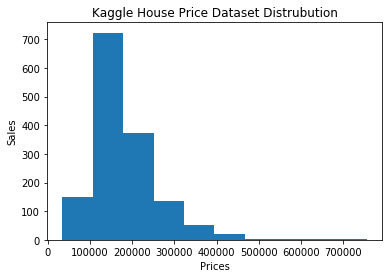

In [4]:
print('Mean: ${}'.format(round(np.mean(df.saleprice))))
plt.hist(df.saleprice)
plt.title('Kaggle House Price Dataset Distrubution')
plt.xlabel('Prices')
plt.xticks()
plt.ylabel('Sales')
plt.show()

The target variable is right-skewed with a somewhat high peak in terms of kurtosis. The mean is 180,921 and prices reach a stretch above 700,000. Let's check how much of the data is captured:

#### Missing Values & Data types

Let's take a look at the missing data and data types:

In [5]:
#count missing values
missing_vals = (df.isnull().sum()/len(df)).sort_values(ascending=False)

# keep column names that do have them
missing_vals = missing_vals[missing_vals > 0]

# data types
missValDTypes = df[missing_vals.index.to_list()].dtypes

printmd("**Missing value percentages:** Total values: {}".format(len(df)))
print(missing_vals, '\n')
printmd("**Data types of missing values:**")
print(missValDTypes)


# del missing_vals
# del missValDTypes

**Missing value percentages:** Total values: 1460

poolqc         0.995
miscfeature    0.963
alley          0.938
fence          0.808
fireplacequ    0.473
lotfrontage    0.177
garageyrblt    0.055
garagequal     0.055
garagecond     0.055
garagefinish   0.055
garagetype     0.055
bsmtexposure   0.026
bsmtfintype2   0.026
bsmtfintype1   0.025
bsmtqual       0.025
bsmtcond       0.025
masvnrarea     0.005
masvnrtype     0.005
electrical     0.001
dtype: float64 



**Data types of missing values:**

poolqc           object
miscfeature      object
alley            object
fence            object
fireplacequ      object
lotfrontage     float64
garageyrblt     float64
garagequal       object
garagecond       object
garagefinish     object
garagetype       object
bsmtexposure     object
bsmtfintype2     object
bsmtfintype1     object
bsmtqual         object
bsmtcond         object
masvnrarea      float64
masvnrtype       object
electrical       object
dtype: object


Looking at missing values, the first few features from poolqc to lotfrontage are amenities/features that do not exist in many houses. From garagecond to garagequal are garage-related features that are missing values for a specific group of rows, which most probably does not have garages. The same goes for the features from bsmtexposure to bsmtqual, masvnrarea, and masvnrtype.

For each of these cases of missing values, there will be a suitable way to fill these values. Columns with over 40% of missing values will be dropped since they relate only to a minority subset of the houses sold, and when they do, they may have low correlation with the saleprice. We will also confirm or remove this doubt after checking for correlation. Most columns have string data types, only 3 are floats. For now, let's store each *case* of missing data as a key for later use:

In [6]:
# Columns to be dropped, pending correlation values
drop_cols = missing_vals[:5].index.to_list()
drop_cols.extend(['id'])

# Columns to be dealt with by case
data_cleaning = {'garage':[i for i in missing_vals.index.to_list() if i.startswith('garage')],
                 'basement':[i for i in missing_vals.index.to_list() if i.startswith('bsmt')],
                 'etc':['masvnrarea','masvnrtype','electrical']}

#### Descriptive Statistics
Since it is tedious to describe a whole dataset from which we will select only some features, we shall focus on the target varaible in hope of understanding realistic target values, their distribution and where a certain predicted value would fall within the distribution.

In [7]:
df['saleprice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: saleprice, dtype: float64

If you are located in the U.S, this would seem like a realistic and normal dataset. Some houses can be sold for as low as 34,900 due to their age, location, type, or any other attribute. A house in the same city but in a different neighborhood can reach 755,000 and would probably have a more luxurious set of amenities included. 

The median for most buyers is 163,000, which is less than the 180,921 mean. This validates our finding in the distribution plot above that the data is not normally distributed.

Let us take a look at the correlation of our data, moving the target column to the front and ordering rows by their correlation with it:

### Univariate & Multivariate Analysis

Starting with univariate analysis, let's draw distributions of features:

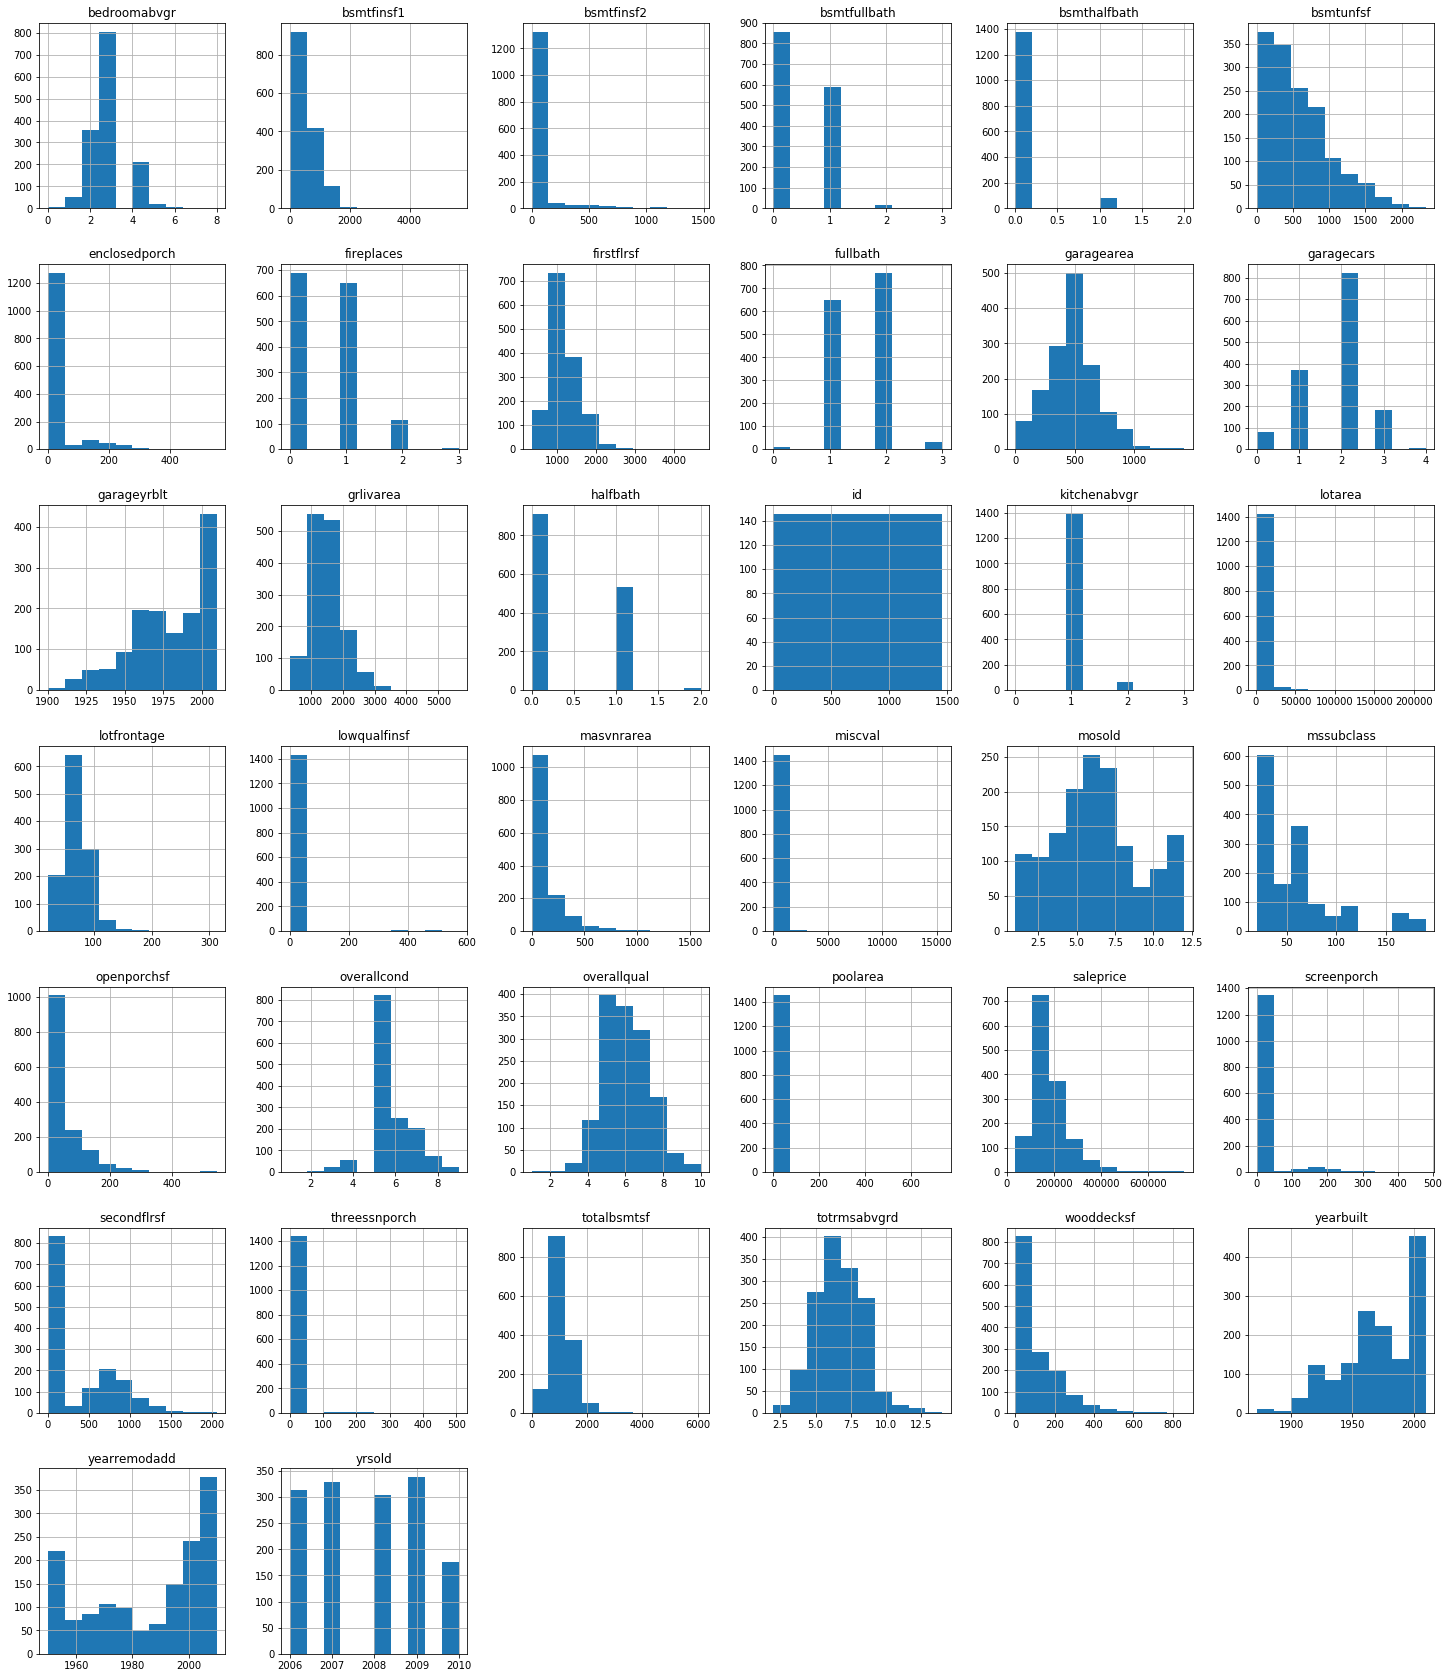

In [8]:
df.hist(figsize=(25,30))
plt.show()

Most features are not normally distributed. This goes against one of assumptions for regression models. 

## Data Cleaning

Up until here, and before we go into multivariate analysis, we have been exploring feature distributions, missing data, and data types. We have decided on a few columns for removal. It makes sense to clean the values we have and check for any improvement in their distribution. Let's begin by removing columns we want to drop:

In [9]:
# Drop columns marked for removal
df.drop(columns=drop_cols, inplace=True)
df = df.replace([np.inf, -np.inf], np.nan).dropna(how="all")

# Deal with missing values
for key in data_cleaning.keys():
    print(key)
    for val in data_cleaning[key]:
        print (val)
        if len(df[val].value_counts()) <= 7:
            print("{}".format(df[val].value_counts()))
        else:
            print("{}".format(df[val].describe()))


garage
garageyrblt
count   1379.000
mean    1978.506
std       24.690
min     1900.000
25%     1961.000
50%     1980.000
75%     2002.000
max     2010.000
Name: garageyrblt, dtype: float64
garagequal
TA    1311
Fa      48
Gd      14
Ex       3
Po       3
Name: garagequal, dtype: int64
garagecond
TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: garagecond, dtype: int64
garagefinish
Unf    605
RFn    422
Fin    352
Name: garagefinish, dtype: int64
garagetype
Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: garagetype, dtype: int64
basement
bsmtexposure
No    953
Av    221
Gd    134
Mn    114
Name: bsmtexposure, dtype: int64
bsmtfintype2
Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: bsmtfintype2, dtype: int64
bsmtfintype1
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: bsmtfintype1, dtype: int64
bsmtqual
TA    649
Gd    618
Ex    121
Fa     35
Name: bsmtqual, dtype: int64
bsm

Based on these values and their counts or description, we will fill in missing values accordingly:

In [10]:
# Create a dictionary containing the value to replace missing values in each column
fill_with = {'garageyrblt': 0, 'garagequal': 'TA', 'garagecond': 'TA', 'garagefinish': 'Unf','garagetype':'No',
             'bsmtexposure':'No','bsmtfintype2':'Unf','bsmtfintype1':'Unf','bsmtqual':'TA','bsmtcond':'TA',
             'masvnrarea':0,'masvnrtype':'None','electrical':'SBrkr'}
df = df.fillna(value=fill_with)

Next, let's transform numerical values and try to reach distributions close to normal. Since it is hard to visualize the normality in all columns at once, we will use the Jargue-Bera and normality tests:

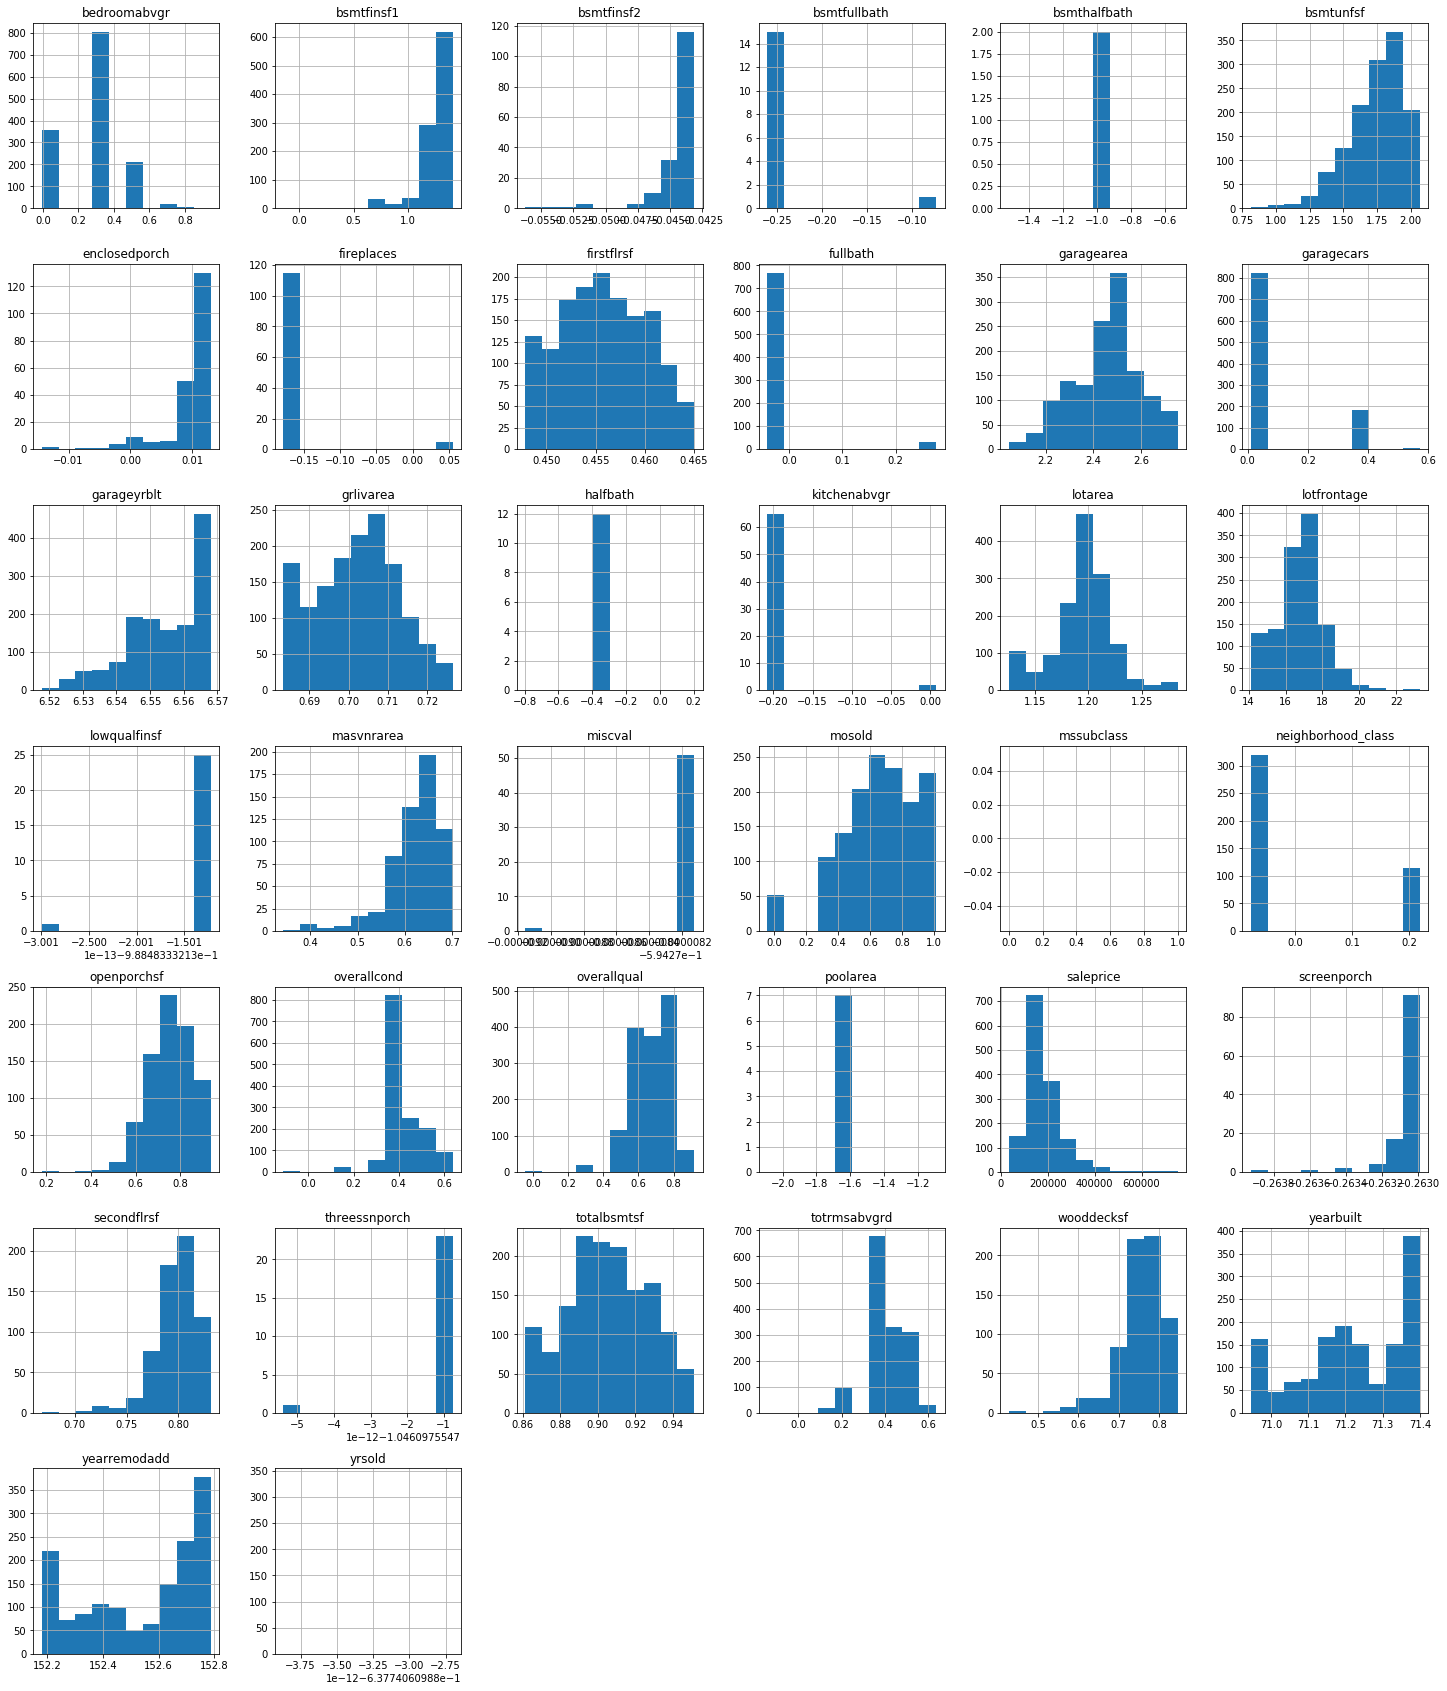

In [27]:
def transform(df, target, transformations=[],box_cox=False):
    """ Winsorizes, transforms, and cleans numeric columns 
        transformations parameter is a list of functions fed to pd.series.apply(), repectively.
        returns transformed dataframe
    """
    
    def bxcx_prep(val):
        """ Transforms values of 0 or less to 0.1 """
        if val <= 0:
            return 0.1
        return val
    
    # Pick numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.to_list()
    numeric_cols.remove(target)
    # Winsorize, log-transform the square root, and plot
    for col in numeric_cols:
        if len(np.unique(df[col])) > 20:
            df[col] = winsorize(df[col], limits = (0.05,0.01))
        if box_cox or any(item in transformations for item in [np.log,np.sqrt]):
            df[col] = df[col].apply(bxcx_prep)
            df[col],_ = boxcox(df[col])
        for transformation in transformations:
            df[col] = df[col].apply(transformation)
        df = df.replace([np.inf, -np.inf], np.nan).dropna(how="all")
    return df

transform(df,'saleprice',[np.sqrt,np.log]).hist(figsize=(25,30)) #[np.sqrt,np.log]
plt.show()



# def test_trans(df, transforms=[], box_cox=False):
#     for trans in tranforms:
#         transform(df,'saleprice',[trans])
        
#     jb_stats = jarque_bera()
#     norm_stats = normaltest()

Winsorizing and transforming values did bring distribution of some variables closer to normal. This should contribute to enhancing our regression models.

How do these different values affect saleprice? Let's start by taking a look at values of each categorical feature in terms of saleprice. This enables us to see how each value affects the saleprice and how it differs from another value for the same feature:

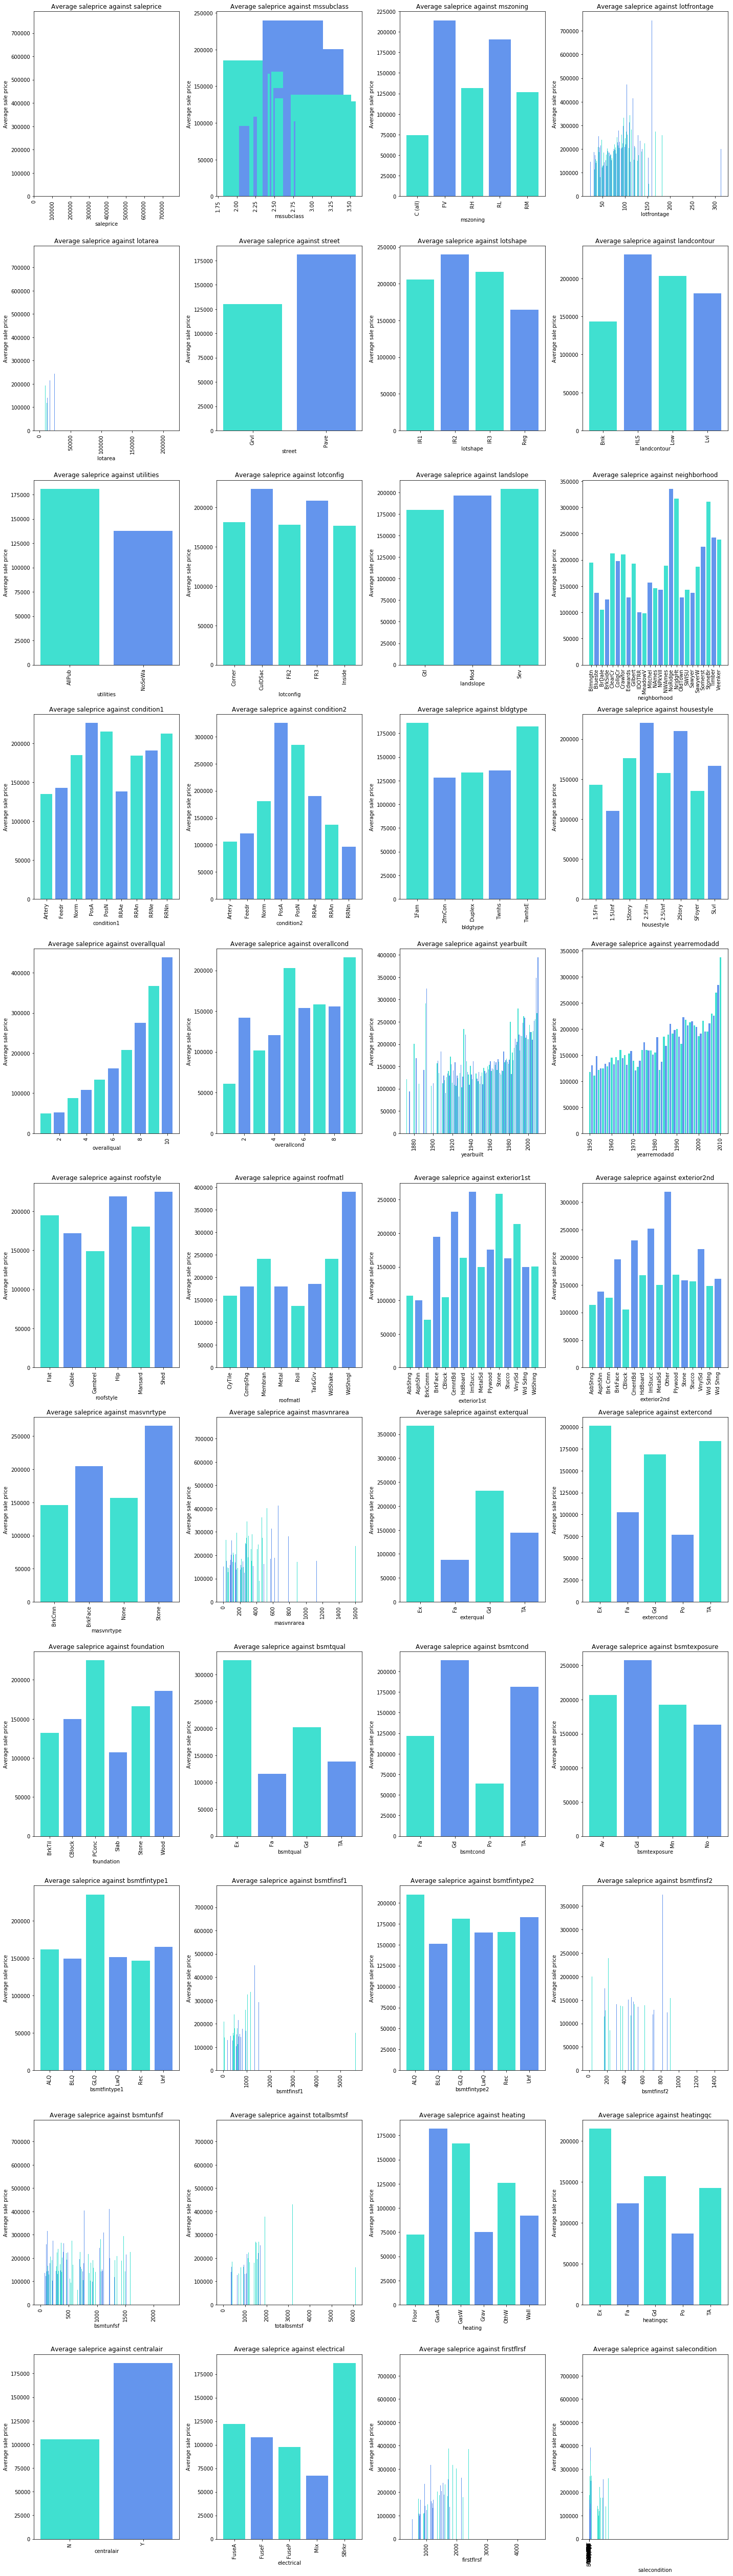

In [12]:
# Plot different bar plots for features against the target
plt.figure(figsize=(20,70))
i = 1
for index, column in enumerate(df.columns):
    plt.subplot(11,4,i)
    
    # Fix this bug: index difference 0,1
    if i < 44:
        i += 1
    else:
        i = 44
        
    plt.bar(df.groupby(column)["saleprice"].mean().index, df.groupby(column)["saleprice"].mean(),color=('turquoise','cornflowerblue'))
    plt.title("Average saleprice against {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

This multi-plot figure makes it easy to see relationships of features with the target. Neighborhoods, street paving, heating and other variables. Since we are looking at a dataset of house sales, one good way to start is by looking at prices across neighborhoods. Houses of the same neighborhood are usually sold for a price within a fixed range for that neighborhood. It also makes sense to order this view from highest to lowest price:

In [13]:
printmd('**Neighborhoods - typical values ordered from most to least expensive**')
# Group data by neighborhood
df.groupby("neighborhood").mean().sort_values(by=['saleprice'],ascending=False)

**Neighborhoods - typical values ordered from most to least expensive**

saleprice  mssubclass  lotfrontage   lotarea  overallqual  \
neighborhood                                                              
NoRidge      335295.317       2.662       91.879 14218.902        7.927   
NridgHt      316270.623       2.607       81.882 10887.948        8.260   
StoneBr      310499.000       2.746       62.700 10671.920        8.160   
Timber       242247.447       2.432       80.133 23664.237        7.158   
Veenker      238772.727       2.601       59.714 15606.000        6.727   
Somerst      225379.837       2.660       64.667  7840.872        7.337   
ClearCr      212565.429       2.605       83.462 30875.750        5.893   
Crawfor      210624.725       2.645       71.805 11809.686        6.275   
CollgCr      197965.773       2.484       71.683  9619.147        6.640   
Blmngtn      194870.882       2.968       47.143  3398.176        7.176   
Gilbert      192854.506       2.691       79.878 11379.152        6.557   
NWAmes       189050.068       2.522       81.289 11833.630        6.329   
SawyerW      186555.797       2.626       71.500  9923.797        6.322   
Mitchel      156270.122       2.571       70.083 11624.286        5.592   
NAmes        145847.080       2.427       76.462 10139.916        5.360   
NPkVill      142694.444       3.071       32.286  3267.444        6.000   
SWISU        142591.360       2.755       58.913  8127.560        5.440   
Blueste      137500.000       3.116       24.000  1625.000        6.000   
Sawyer       136793.135       2.436       74.438 10459.284        5.027   
OldTown      128225.301       2.683       62.789  8207.062        5.389   
Edwards      128219.700       2.568       68.217 10218.650        5.080   
BrkSide      124834.052       2.606       57.510  7360.414        5.052   
BrDale       104493.750       3.116       21.562  1801.000        5.688   
IDOTRR       100123.784       2.621       62.500  8109.162        4.757   
MeadowV       98576.471       3.121       27.800  2324.000        4.471   

              overallcond  yearbuilt  yearremodadd  masvnrarea  bsmtfinsf1  \
neighborhood                                                                 
NoRidge             5.220   1995.439      1996.659     420.024     829.756   
NridgHt             5.000   2005.675      2006.169     329.545     696.779   
StoneBr             5.000   1998.480      1998.840     182.760     822.920   
Timber              5.132   1992.842      1993.342     159.947     708.500   
Veenker             6.273   1982.364      1989.818      32.727     819.909   
Somerst             5.035   2004.988      2005.302     150.326     327.198   
ClearCr             5.679   1966.571      1983.750      84.571     620.893   
Crawfor             6.588   1941.549      1979.196      81.118     466.804   
CollgCr             5.240   1997.887      1999.140      97.227     456.587   
Blmngtn             5.000   2005.235      2005.765      45.588     196.000   
Gilbert             5.127   1998.253      1998.823      41.519     214.025   
NWAmes              5.945   1975.630      1981.521     177.562     510.466   
SawyerW             5.153   1988.559      1989.983      70.898     543.559   
Mitchel             5.367   1981.755      1985.551      61.306     641.245   
NAmes               5.791   1959.996      1971.622     101.142     485.609   
NPkVill             5.556   1976.444      1976.444       0.000     444.222   
SWISU               5.920   1925.240      1969.680      10.080     208.520   
Blueste             6.000   1980.000      1980.000       0.000     183.000   
Sawyer              5.811   1963.676      1978.527      41.041     508.486   
OldTown             6.354   1922.885      1975.425      14.195     163.611   
Edwards             5.440   1955.970      1975.110      50.470     424.460   
BrkSide             6.138   1931.431      1968.586       7.397     195.741   
BrDale              5.438   1971.438      1973.625     307.562     250.438   
IDOTRR              5.541   1927.946  

NoRidge, NridgHt and StoneBr are the most expensive neighborhoods in this dataset. Some of their features are significantly different than those of other neighborhoods. 



In [14]:
def classify_nbr(saleprice):
    """ puts houses in preset neighborhood bins """
    
    nbr_class = {0:'saleprice < 120000',
                 1:'saleprice >= 120000 and saleprice < 200000',
                 2:'saleprice >= 200000 and saleprice < 300000',
                 3:'saleprice >= 300000'}
    for class_level in nbr_class.keys():
        if eval(nbr_class[class_level]):
            return class_level

df['neighborhood_class'] = df['saleprice'].apply(classify_nbr)

In [15]:
# make the correlation matrix.
corr_mat_houses = df.corr()

printmd('\n **Correlation dataframe sorted by correlation with saleprice descending:**')
corr_mat_houses.sort_values(by=['saleprice'],ascending=False)


 **Correlation dataframe sorted by correlation with saleprice descending:**

saleprice  mssubclass  lotfrontage  lotarea  overallqual  \
saleprice               1.000      -0.026        0.352    0.264        0.791   
neighborhood_class      0.892      -0.038        0.348    0.247        0.755   
overallqual             0.791       0.084        0.252    0.106        1.000   
grlivarea               0.709       0.211        0.403    0.263        0.593   
garagecars              0.640      -0.007        0.286    0.155        0.601   
garagearea              0.623      -0.076        0.345    0.180        0.562   
totalbsmtsf             0.614      -0.292        0.392    0.261        0.538   
firstflrsf              0.606      -0.300        0.457    0.299        0.476   
fullbath                0.561       0.188        0.199    0.126        0.551   
totrmsabvgrd            0.534       0.179        0.352    0.190        0.427   
yearbuilt               0.523      -0.015        0.123    0.014        0.572   
yearremodadd            0.507       0.036        0.089    0.014        0.551   
masvnrarea              0.473       0.033        0.192    0.103        0.407   
fireplaces              0.467       0.015        0.267    0.271        0.397   
bsmtfinsf1              0.386      -0.123        0.234    0.214        0.240   
lotfrontage             0.352      -0.314        1.000    0.426        0.252   
wooddecksf              0.324       0.000        0.089    0.172        0.239   
secondflrsf             0.319       0.512        0.080    0.051        0.295   
openporchsf             0.316       0.035        0.152    0.085        0.309   
halfbath                0.284       0.307        0.054    0.014        0.273   
lotarea                 0.264      -0.122        0.426    1.000        0.106   
garageyrblt             0.261      -0.057        0.105    0.073        0.289   
bsmtfullbath            0.227      -0.051        0.101    0.158        0.111   
bsmtunfsf               0.214      -0.129        0.133   -0.003        0.308   
bedroomabvgr            0.168       0.084        0.263    0.120        0.102   
screenporch             0.111      -0.012        0.041    0.043        0.065   
poolarea                0.092       0.027        0.206    0.078        0.065   
mosold                  0.046       0.014        0.011    0.001        0.071   
threessnporch           0.045      -0.047        0.070    0.020        0.030   
bsmtfinsf2             -0.011      -0.094        0.050    0.111       -0.059   
bsmthalfbath           -0.017       0.006       -0.007    0.048       -0.040   
miscval                -0.021      -0.013        0.003    0.038       -0.031   
mssubclass             -0.026       1.000       -0.314   -0.122        0.084   
lowqualfinsf           -0.026       0.070        0.038    0.005       -0.030   
yrsold                 -0.029      -0.029        0.007   -0.014       -0.027   
overallcond            -0.078      -0.034       -0.059   -0.006       -0.092   
enclosedporch          -0.129       0.034        0.011   -0.018       -0.114   
kitchenabvgr           -0.136       0.248       -0.006   -0.018       -0.184   

                    overallcond  yearbuilt  yearremodadd  masvnrarea  \
saleprice                -0.078      0.523         0.507       0.473   
neighborhood_class       -0.059      0.539         0.523       0.401   
overallqual              -0.092      0.572         0.551       0.407   
grlivarea                -0.080      0.199         0.287       0.388   
garagecars               -0.186      0.538         0.421       0.362   
garagearea               -0.152      0.479         0.372       0.371   
totalbsmtsf              -0.171      0.391         0.291       0.360   
firstflrsf               -0.144      0.282         0.240       0.340   
fullbath                 -0.194      0.468         0.439       0.273   
totrmsabvgrd             -0.058      0.096         0.192       0.280   
yearbuilt                -0.376      1.000         0.593       0.312   
yearremodadd              0.074    

The columns we have chosen as features before can be seen in the top rows. None of the negatively correlated features are significant enough to include within the model's features. To visualize this table, let's draw a correlation matrix, filtering out correlation less than a set threshold for a focused view on relevant features:

**Correlation Matrix (filtered for correlation above 0.64):**

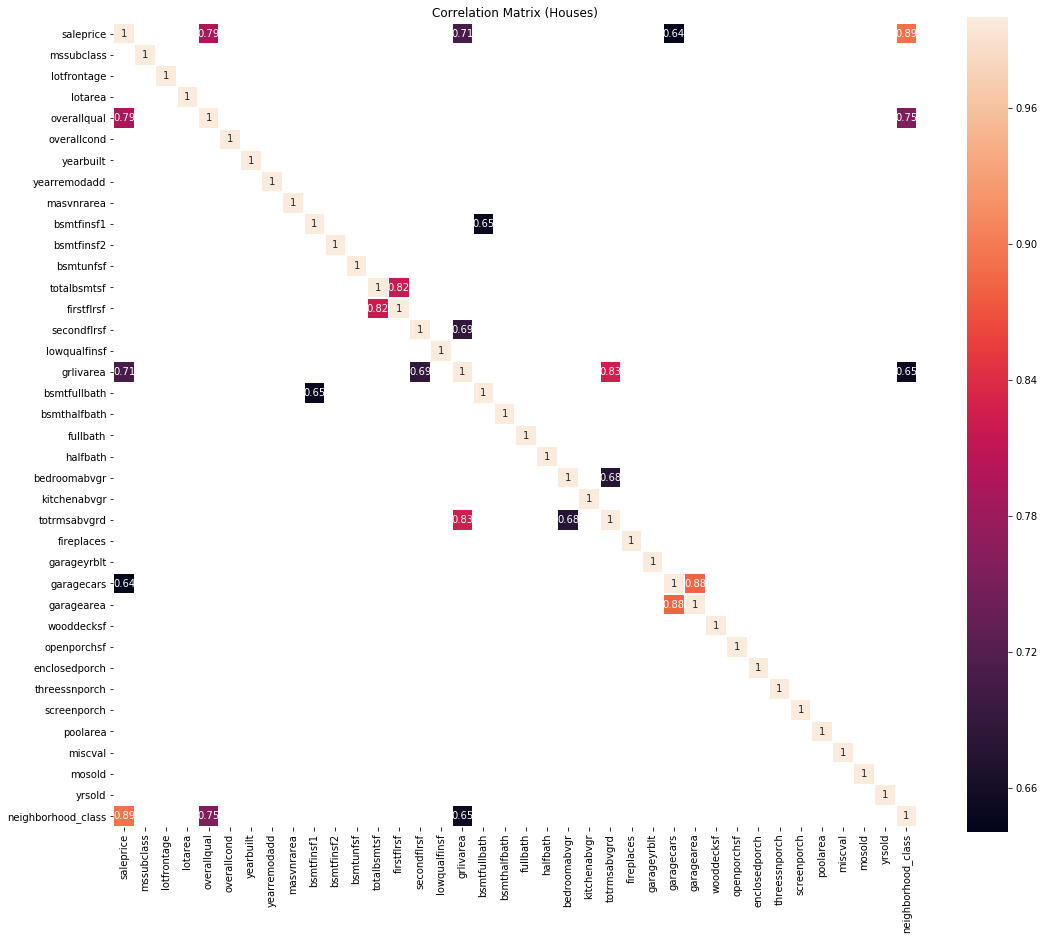

features are: ['overallqual', 'grlivarea', 'garagecars', 'neighborhood_class']


In [16]:
def draw_heatmap(df,corr_thresh=.7):
    """ Draws heatmap out of a dataframe. 
        Set corr_thresh to 0 for full heatmap,
        or keep default for strong correlation
    """
    
    # make the correlation matrix.
    corr_mat = df.corr()

    # move the column to head of list using index, pop and insert
    cols = list(corr_mat)
    cols.insert(0, cols.pop(cols.index('saleprice')))

    # reorder
    corr_mat = corr_mat.ix[:, cols]
    corr_mat.sort_values(by=['saleprice'],ascending=False)

    # figure aesthetics
    plt.figure(figsize=(18,15))
    plt.plot()
    
    # draw the heatmap using seaborn.
    sns.heatmap(corr_mat[(corr_mat > corr_thresh)], square=True, annot=True, linewidths=.5)
    plt.title("Correlation Matrix (Houses)")
    printmd("**Correlation Matrix (filtered for correlation above {}):**".format(corr_thresh))
    plt.show()
    
    # return features that correlate with the target equal to corr_thresh or higher
    features = corr_mat[(corr_mat > corr_thresh)]
    features = features.index[features['saleprice'] >= corr_thresh].tolist()
    features.remove('saleprice')
    print('features are: {}'.format(features))
    return features

corr_thresh = 0.64
features = draw_heatmap(df,corr_thresh)


    
# del corr_mat_houses

Several values were tried in order to choose a threshold. Our correlation threshold here is 0.64. This will be the _initial_ basis on which we base our feature selection. Let's build our second model based on features selected, removing overallqual and grlivarea since they both have high correlation with neighborhood_class :

In [17]:
# Initial model prep
temp_df = df[['saleprice',
              'overallqual',
              'grlivarea',
              'garagecars']]

def log_prep(temp_df):
    """takes in the chosen temp_df for the model and outputs X & Y with saleprice log-transformed"""
    
    # Log-transform salesprice values & drop saleprice
    temp_df['saleprice_log'] = np.log(temp_df['saleprice'])
    temp_df.drop(columns=['saleprice'],inplace=True)
    
    # designate features
    features = list(temp_df.columns)
    features.remove('saleprice_log')
    print('features (len: {}): {}\ntarget: {}'.format(len(features),{i for i in features},list(set(set(temp_df.columns)-set(features)))))

    # X & Y
    X = temp_df[features]
    Y = temp_df['saleprice_log']
    return X,Y

X, Y = log_prep(temp_df)

features (len: 3): {'overallqual', 'garagecars', 'grlivarea'}
target: ['saleprice_log']


It seems that PCA is not needed for this specific model as the features are few. Since we will be building several models, we will come back to this step at some point and perform some more feature engineering.

# Now, split your data into train and test sets where 20% of the data resides in the test set.

In [18]:

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


# Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!


#### Model I : 



This is the model we built up until now in this challenge. The following features are based on 0.7 or more correlation, and overallqual and grlivarea are removed due to correlating strongly with neighborhood_class :

In [19]:
features_1 = ['saleprice', 'neighborhood_class', 'garagecars']
temp_df = df[features_1]

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          saleprice_log   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     1697.
Date:                Sun, 13 Oct 2019   Prob (F-statistic):               0.00
Time:                        17:01:22   Log-Likelihood:                 365.95
No. Observations:                1460   AIC:                            -723.9
Df Residuals:                    1456   BIC:                            -702.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.5811      0.022    470.640      0.000      10.537      10.625
overallqual     0.1434      0.005     28.806      0.000       0.134       0.153
grlivarea       0.0002   1.18e-05     18.705      0.000       0.000       0.000
garagecars      0.1316      0.008     15.690      0.000       0.115       0.148
==============================================================================
Omnibus:                      432.881   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2744.365
Skew:                          -1.225   Prob(JB):                         0.00
Kurtosis:                       9.254   Cond. No.                     7.40e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model II : From previous lessons

This is the most up-to-date model from previous lessons.

In [20]:
# Initial model prep
features_2 = ['saleprice','overallqual','grlivarea',
              'garagecars', 'totalbsmtsf', 'fullbath',
              'yearbuilt', 'yearremodadd']
temp_df = df[features_2]

X, Y = log_prep(temp_df)

features (len: 7): {'overallqual', 'totalbsmtsf', 'yearbuilt', 'fullbath', 'yearremodadd', 'grlivarea', 'garagecars'}
target: ['saleprice_log']


In [21]:
results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          saleprice_log   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.025e+06
Date:                Sun, 13 Oct 2019   Prob (F-statistic):                        0.00
Time:                        17:01:22   Log-Likelihood:                          505.47
No. Observations:                1460   AIC:                                     -996.9
Df Residuals:                    1453   BIC:                                     -959.9
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
overallqual      0.0827      0.005     16.878      0.000       0.073       0.092
grlivarea        0.0003   1.28e-05     20.915      0.000       0.000       0.000
garagecars       0.0785      0.008      9.846      0.000       0.063       0.094
totalbsmtsf      0.0001   1.27e-05      9.686      0.000    9.83e-05       0.000
fullbath        -0.0364      0.011     -3.215      0.001      -0.059      -0.014
yearbuilt        0.0023      0.000     11.197      0.000       0.002       0.003
yearremodadd     0.0032      0.000     15.928      0.000       0.003       0.004
==============================================================================
Omnibus:                      975.003   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42404.231
Skew:                          -2.524   Prob(JB):                         0.00
Kurtosis:                      28.915   Cond. No.                     8.56e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R2 & Adj. R-squared are 1, which is high. The F-statistic is higher, the AIC and BIC are lower than the ones seen previously, which means the additional features in the model are contributing additional information. This model has performed better than the one we developed in this challenge so far in . Since these two models carry the best features based on correlation, it would be a good idea to combine their features in a third model.

#### Model III

This model will take features from Model I and adds to it features from Model II that have low multicollinearity. This means we will be removing overallqual and grlivarea from Model III:

In [22]:
features_3 = list(set(features_1 + features_2)-set(['overallqual','grlivarea']))
temp_df = df[features_3]

X, Y = log_prep(temp_df)

features (len: 6): {'neighborhood_class', 'totalbsmtsf', 'yearbuilt', 'fullbath', 'yearremodadd', 'garagecars'}
target: ['saleprice_log']


In [23]:
results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          saleprice_log   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.525e+06
Date:                Sun, 13 Oct 2019   Prob (F-statistic):                        0.00
Time:                        17:01:22   Log-Likelihood:                          682.31
No. Observations:                1460   AIC:                                     -1353.
Df Residuals:                    1454   BIC:                                     -1321.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
neighborhood_class     0.2935      0.007     40.265      0.000       0.279       0.308
totalbsmtsf         8.923e-05   1.13e-05      7.864      0.000     6.7e-05       0.000
yearbuilt              0.0013      0.000      7.752      0.000       0.001       0.002
fullbath               0.0436      0.009      4.983      0.000       0.026       0.061
yearremodadd           0.0044      0.000     26.023      0.000       0.004       0.005
garagecars             0.0449      0.007      6.265      0.000       0.031       0.059
==============================================================================
Omnibus:                      151.163   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              605.720
Skew:                          -0.431   Prob(JB):                    2.95e-132
Kurtosis:                       6.036   Cond. No.                     7.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This third model is superior to both previous models. Removing overallqual and grlivarea from Model II in order to replace them with neighborhood_class seems to have contributed a good bit to the model's .

# Evaluate your best model on the test set.



# So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.
